<a href="https://colab.research.google.com/github/YanaSemenenya/INTERPRETATOR/blob/develop/Examples/Economic_effect_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk Prediction
**Xin Zhao**
<br>
This is a case study on Home Credit Default Risk Prediction using data from Home Credit Group and various machine learning algorithms. Techniques on feature selection and principal component analysis are also considered. In the end, XGBoost algorithm is selected. The prediction AUC score is 0.75. 

### Загрузка данных

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"falconwatch","key":"852b6d7f11534bcc686e2d63c56e894e"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'home-credit-default-risk'

 68% 25.0M/36.8M [00:00<00:00, 54.4MB/s]
100% 36.8M/36.8M [00:00<00:00, 82.1MB/s]
 95% 257M/271M [00:02<00:00, 89.7MB/s]
100% 271M/271M [00:02<00:00, 106MB/s] 
 84% 81.0M/96.7M [00:01<00:00, 90.3MB/s]
100% 96.7M/96.7M [00:01<00:00, 90.6MB/s]
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 26.0MB/s]
  0% 0.00/524k [00:00<?, ?B/s]
100% 524k/524k [00:00<00:00, 134MB/s]
 83% 63.0M/76.3M [00:00<00:00, 76.5MB/s]
100% 76.3M/76.3M [00:00<00:00, 96.1MB/s]
 72% 26.0M/36.1M [00:00<00:00, 71.1MB/s]
100% 36.1M/36.1M [00:00<00:00, 102MB/s] 
 86% 5.00M/5.81M [00:00<00:00, 42.9MB/s]
100% 5.81M/5.81M [00:00<00:00, 37.1MB/s]
 87% 95.0M/109M [00:01<00:00, 86.9MB/s]
100% 109M/109M [00:01<00:00, 93.8MB/s] 
 72% 41.0M/56.8M [00:00<00:00, 68.9MB/s]
100% 56.8M/56.8M [00:00<00:00, 96.7MB/s]


In [4]:
! unzip application_train.csv.zip application_train.csv
! unzip application_test.csv.zip application_test.csv
! unzip bureau.csv.zip bureau.csv

Archive:  application_train.csv.zip
  inflating: application_train.csv   
Archive:  application_test.csv.zip
  inflating: application_test.csv    
Archive:  bureau.csv.zip
  inflating: bureau.csv              


### Импортируем библиотеки

In [5]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib, matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb

In [6]:
from collections import defaultdict

# Explore and process bureau data

In [7]:
bureau = pd.read_csv('bureau.csv')

## Shape

In [8]:
bureau.shape

(1716428, 17)

## Categorical features in bureau

In [9]:
cat_features = bureau.select_dtypes(include='object').columns.tolist()
cat_features

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']


## Label encode the categorical features

In [10]:
bureau_transform = bureau.copy()

In [11]:
encoded_features = defaultdict(dict)
for col in cat_features:
    label_encoder = LabelEncoder()
    uniq_labels = bureau_transform[col].unique()
    bureau_transform[col] = label_encoder.fit_transform(bureau_transform[col])
    encoded_features[col] = dict(zip(uniq_labels,label_encoder.transform(uniq_labels)))

In [12]:
encoded_features

defaultdict(dict,
            {'CREDIT_ACTIVE': {'Active': 0,
              'Bad debt': 1,
              'Closed': 2,
              'Sold': 3},
             'CREDIT_CURRENCY': {'currency 1': 0,
              'currency 2': 1,
              'currency 3': 2,
              'currency 4': 3},
             'CREDIT_TYPE': {'Another type of loan': 0,
              'Car loan': 1,
              'Cash loan (non-earmarked)': 2,
              'Consumer credit': 3,
              'Credit card': 4,
              'Interbank credit': 5,
              'Loan for business development': 6,
              'Loan for purchase of shares (margin lending)': 7,
              'Loan for the purchase of equipment': 8,
              'Loan for working capital replenishment': 9,
              'Microloan': 10,
              'Mobile operator loan': 11,
              'Mortgage': 12,
              'Real estate loan': 13,
              'Unknown type of loan': 14}})

In [13]:
#feature_encode = onehot_encoder.get_feature_names(cat_features)
#bureau_cat_encode.columns = feature_encode
#bureau_cat_encode

## Extract numerical features and combine into the encoded categorical data

In [14]:
#num_features = ['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT']
#bureau_num = bureau[num_features] 
#bureau_proc = pd.concat([bureau_num, bureau_cat_encode], axis=1)
#print(bureau_proc.shape)
#print(bureau_num.shape)
#print(bureau_cat_encode.shape)

## Group sum and mean bureau data by loan ID

In [15]:
bureau_proc_sum = bureau_transform.groupby(['SK_ID_CURR']).sum()
bureau_proc_mean = bureau_transform.groupby(['SK_ID_CURR']).mean()

### Rename columns

In [16]:
new_collist_sum = []
for col in bureau_proc_sum.columns:
    if col == 'SK_ID_CURR':
        continue
    new_collist_sum.append(col + ' SUMBYID')
colname_dict = dict(zip(bureau_proc_sum.columns, new_collist_sum))
bureau_proc_sum = bureau_proc_sum.rename(columns=colname_dict)

In [17]:
new_collist_mean = []
for col in bureau_proc_mean.columns:
    if col == 'SK_ID_CURR':
        continue
    new_collist_mean.append(col + ' MEANBYID')
colname_dict_mean = dict(zip(bureau_proc_mean.columns, new_collist_mean))
bureau_proc_mean = bureau_proc_mean.rename(columns=colname_dict_mean)

### MERGE mean and sum bureau data

In [18]:
bureau_proc_final = pd.merge(bureau_proc_sum, bureau_proc_mean, how='left', on='SK_ID_CURR')

In [19]:
bureau_proc_final.to_csv('bureau_proc_final.csv', index=True)

In [20]:
bureau_proc_final = pd.read_csv('bureau_proc_final.csv')

# Process application_train/test

In [21]:
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')

## Check if 'SK_ID_CURR' in the train data

In [22]:
'SK_ID_CURR' in application_train.columns

True

## Merge bureau_proc_final to application data

In [23]:
train_merged = pd.merge(application_train, bureau_proc_final, how='left', on='SK_ID_CURR')
test_merged = pd.merge(application_test, bureau_proc_final, how='left', on='SK_ID_CURR')
print(application_train.shape)
print(train_merged.shape)
print(application_test.shape)
print(test_merged.shape)

(307511, 122)
(307511, 154)
(48744, 121)
(48744, 153)


## Drop ID columns for training

In [24]:
train_merged.drop('SK_ID_CURR', axis=1, inplace=True)
test_merged.drop('SK_ID_CURR', axis=1, inplace=True)

### DROP SOME FEATURES

In [25]:
features_to_drop = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE']
for feature in train_merged.columns:
    if 'FLAG_DOCUMENT' in feature:
        features_to_drop.append(feature)
train_merged.drop(features_to_drop, axis = 1, inplace = True)
test_merged.drop(features_to_drop, axis = 1, inplace = True)

### ADD NEW FEATURES

In [26]:
train_merged['PRICE/CREDIT'] = train_merged['AMT_GOODS_PRICE']/train_merged['AMT_CREDIT']
test_merged['PRICE/CREDIT'] = test_merged['AMT_GOODS_PRICE']/test_merged['AMT_CREDIT']

## Extract numerical and categorical features for further processing: impute, scaling

In [27]:
num_features_1 = train_merged.select_dtypes(include='int64').columns.tolist()
num_features_1.remove('TARGET')

In [28]:
num_features_2 = train_merged.select_dtypes(include='float64').columns.tolist()

In [29]:
cat_features = train_merged.select_dtypes(include='object').columns.tolist()

In [30]:
num_features = num_features_1 + num_features_2
features = num_features + cat_features

### EDA

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

 ### Обработка данных


Заполняем пропущенные значеня в вещественных фичах

In [33]:
for feature in num_features:
    fill_value = train_merged[feature].mean()
    train_merged[feature].fillna(fill_value, inplace = True)
    test_merged[feature].fillna(fill_value, inplace = True)

In [ ]:
np.sum(train_merged[num_features].isna().sum() != 0)

Заполняем пропущенные значения в категориальных фичах и делаем лейбл энкодинг

In [ ]:
for feature in cat_features:
    train_merged[feature].fillna('missing', inplace = True)
    test_merged[feature].fillna('missing', inplace = True)
    label_encoder = LabelEncoder()
    uniq_labels = train_merged[feature].unique()
    train_merged[feature] = label_encoder.fit_transform(train_merged[feature])

    encoded_features[feature] = dict(zip(uniq_labels,label_encoder.transform(uniq_labels)))
    test_merged[feature] = label_encoder.transform(test_merged[feature])

In [ ]:
train_merged[cat_features].isna().sum()

### Сохраняем данные и делим выделяем таргер

In [ ]:
#train_merged['AGE/EXPERIENCE'] = train_merged['DAYS_BIRTH']/train_merged['DAYS_EMPLOYED']
#test_merged['AGE/EXPERIENCE'] = test_merged['DAYS_BIRTH']/test_merged['DAYS_EMPLOYED']

In [ ]:
train_merged.to_csv('train_merged.csv', index= False)
test_merged.to_csv('test_merged.csv', index = False)


In [ ]:
X_train = train_merged.drop(['TARGET'], axis = 1)
X_test = test_merged.copy()
y_train = train_merged.TARGET.values
print('X_train shape:', X_train.shape)

### TRAINING XGB Model

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", 
                              max_depth=4,learning_rate=0.277, gamma=0.382)
xgb_model.fit(X_train, y_train)

In [ ]:
import sklearn.metrics as metrics
def plot_AUC(model,X_test,y_test):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
plot_AUC(xgb_model, X_train, y_train)

# Calculate training accuracy

In [ ]:
print(roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:,1]))

0.7662371100295048


# Get prediction

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['TARGET'] =xgb_model.predict_proba(X_test)[:,1]
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.054460
1,100005,0.161407
2,100013,0.026001
3,100028,0.025872
4,100038,0.126772


# Save the submission 

In [ ]:
submission.to_csv('my_submission.csv', index=False)

### Интерпретации

In [ ]:
import shap 

class BaseInterpretator:
    """
    Базовый класс интерпретатора
    """

    def __init__(self, model):
        """
        Создаёт объект интерпретатора
        :param model: Модель для интерпретации
        """
        self.__model = model
    
    def fit_shap(self):
        self.__explainer = shap.TreeExplainer(self.__model)
        return

    def shap(self, data, type = 'summary_plot', num_features = None):
        """
        Плейсхолдер для метода интепретации
        :param data: Данные, на которых построенна модель. Используются для отдельных видоп интепретации
        :return: Возвращает результат интепретации
        """
        if type == 'summary_plot':
            shap_values = self.__explainer.shap_values(data)
            return shap.summary_plot(shap_values, data, max_display = num_features)
        if type == 'summary_bar_plot':
            shap_values = self.__explainer.shap_values(data)
            return shap.summary_plot(shap_values, data, plot_type='bar', max_display = num_features)
        if type == 'individual_plot':
            shap.initjs()
            shap_value_sample = self.__explainer.shap_values(data)
            return shap.force_plot(self.__explainer.expected_value, shap_value_sample, data)


In [ ]:
interp = BaseInterpretator(xgb_model)

In [ ]:
interp.fit_shap()

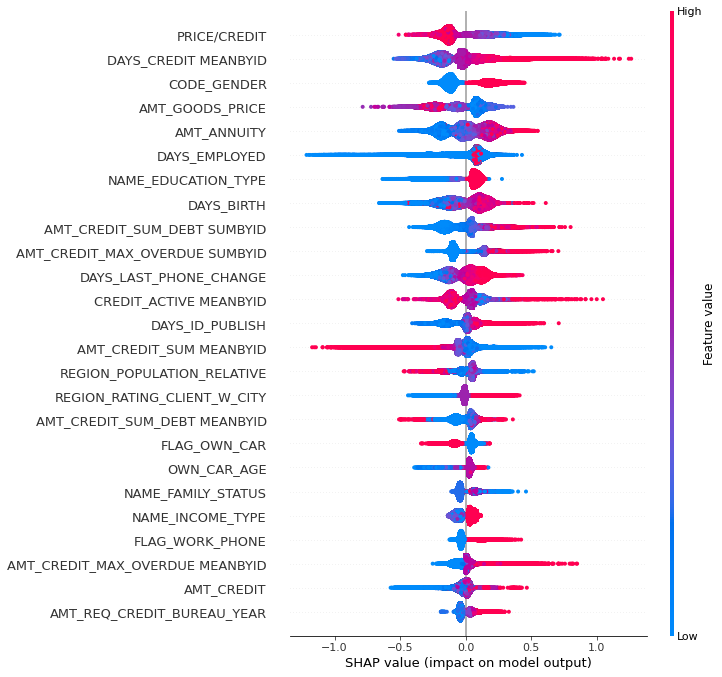

In [ ]:
interp.shap(X_train, type = 'summary_plot', num_features = 25)

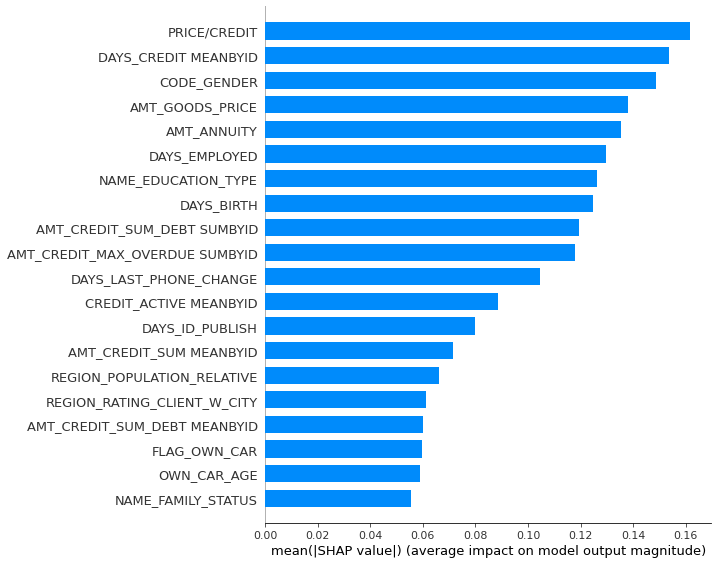

In [ ]:
interp.shap(X_train, type = 'summary_bar_plot')

In [ ]:
sample = X_train.sample(1,random_state=42)
interp.shap(sample, type = 'individual_plot')

In [ ]:
sample = X_test.sample(1,random_state=42)
interp.shap(sample, type = 'individual_plot')

In [ ]:
X_train.shape

(307511, 130)

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 23.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491625 sha256=f53368164dfc2e7ce515119fbe68b25f2b652c356ec47ee8f952369c2a149d3a
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

In [ ]:
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)

(307511, 128)


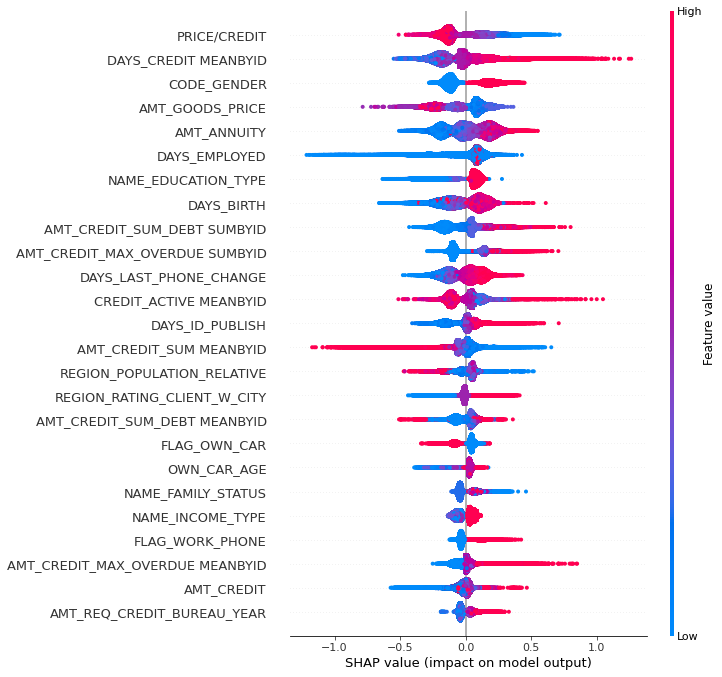

In [ ]:
shap.summary_plot(shap_values,X_train, max_display = 25)

In [ ]:
encoded_features

defaultdict(dict,
            {'CODE_GENDER': {'F': 0, 'M': 1, 'XNA': 2},
             'CREDIT_ACTIVE': {'Active': 0,
              'Bad debt': 1,
              'Closed': 2,
              'Sold': 3},
             'CREDIT_CURRENCY': {'currency 1': 0,
              'currency 2': 1,
              'currency 3': 2,
              'currency 4': 3},
             'CREDIT_TYPE': {'Another type of loan': 0,
              'Car loan': 1,
              'Cash loan (non-earmarked)': 2,
              'Consumer credit': 3,
              'Credit card': 4,
              'Interbank credit': 5,
              'Loan for business development': 6,
              'Loan for purchase of shares (margin lending)': 7,
              'Loan for the purchase of equipment': 8,
              'Loan for working capital replenishment': 9,
              'Microloan': 10,
              'Mobile operator loan': 11,
              'Mortgage': 12,
              'Real estate loan': 13,
              'Unknown type of loan': 14},
       

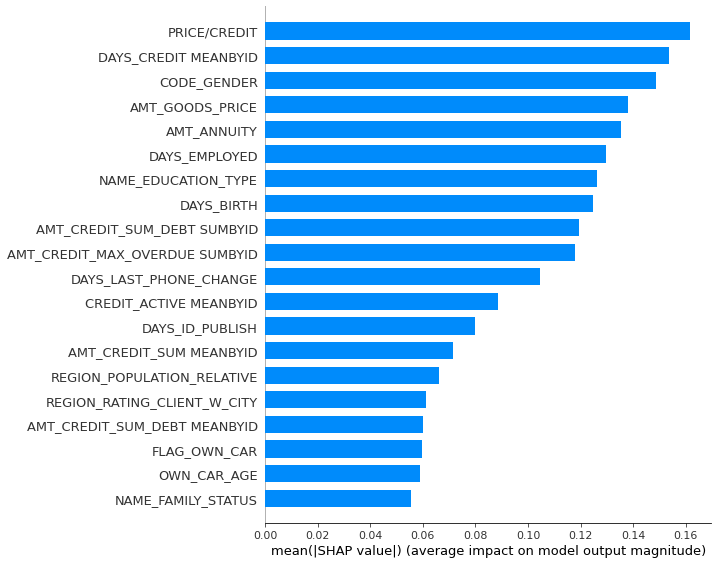

In [ ]:
shap.summary_plot(shap_values,X_train,plot_type='bar')

In [ ]:
!pip install -U Skater

### EDA

In [ ]:
import seaborn as sns

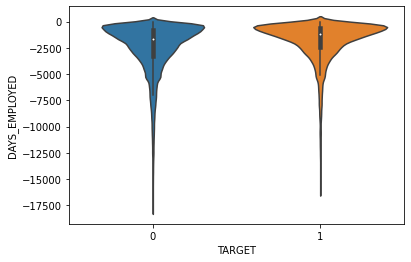

In [ ]:
ax = sns.violinplot(x='TARGET', y="DAYS_EMPLOYED", data=train_merged[train_merged["DAYS_EMPLOYED"] < 25000])